## Imports

In [9]:
import pandas as pd
from pathlib import Path
import numpy as np
import json
import warnings
import math

from typing import Dict, Tuple
from collections import defaultdict
import sklearn.linear_model as sklearn_linear_model
import sklearn.metrics as sklearn_metrics
import sklearn.model_selection as sklearn_model_selection
import sklearn.preprocessing as sklearn_preprocessing
import sklearn.feature_selection as sklearn_feature_selection
import sklearn.ensemble as sklearn_ensemble
import sklearn.decomposition as sklearn_decomposition
from sklearn.impute import SimpleImputer

import dask.dataframe as ddf

import geopandas as gpd
import dask_geopandas as dgpd

import matplotlib.pyplot as plt
import pyreadstat
from pandas.api.types import is_numeric_dtype

In [10]:
data_path = Path('/home/selker/eop/data')

malawi_directory = data_path / 'malawi'

mosaiks_directory = data_path / 'mosaiks'

Out: 
* A data file, one-hot encoded and imputed as in roshni's replication code, with all columns included
* A summary like I construct: with "dropped" indicating either dropped for missingness, or omitted because we don't want it (say, consumption qs)
* summary should include a one-hot map, i.e. a column containing one-hat categories

# LSMS data

### Common cleaning function

In [11]:
def columns_equal(df, col1, col2):
    c1 = df[col1]
    c2 = df[col2]

    if pd.api.types.is_numeric_dtype(c1) and pd.api.types.is_numeric_dtype(c2):
        return np.isclose(c1, c2, rtol=1e-4, equal_nan=True).all()
    else:
        try:
            eq = (c1 == c2).all()
        except TypeError:
            # mismatched categories -> this comparison raises a type error
            eq = False
        return eq

# Inputs by survey year

# https://docs.google.com/spreadsheets/d/11I0U413LgiVYuvgPhVL1M-5bfJabCFql75tQWG551U0/edit#gid=0
currency_conversion_factors = {
    2016: 0.00461055475,
    2019: 0.003361742723912196
}

survey_directories = {
    2016: malawi_directory / 'MWI_2016_IHS-IV_v04_M_STATA14',
    2019: malawi_directory / 'MWI_2019_IHS-V_v06_M_Stata'
}

roster_paths = {
    2016: survey_directories[2016] / 'household/hh_mod_b',
    2019: survey_directories[2019] / 'HH_MOD_B'
}

file_lists = {
    2016: [
        survey_directories[2016] / f for f in (
            'household/hh_mod_a_filt',
            'household/hh_mod_f', # housing
            'household/hh_mod_h', # food security
            'household/hh_mod_n1', # household enterprises
            'household/hh_mod_s2', # household credit
            'household/hh_mod_t', # subj assessment of well-being
            'household/hh_mod_x', # ag and fisheries filter,
            'agriculture/ag_mod_a', # ownership of land
            'agriculture/ag_mod_r2', # livestock
            'agriculture/ag_mod_e3', # coupon use - rainy season
            'household_geovariables/householdgeovariablesihs4', # geo
            'consumption_aggregate/ihs4 consumption aggregate' # consumption
        )
    ],
    2019: [
        survey_directories[2019] / f for f in (
            'HH_MOD_F', # household level data
            'HH_MOD_H', # food security
            'HH_MOD_N1', # household enterprises
            'HH_MOD_S2', # household credit
            'HH_MOD_T', # subjective assessment of well-being
            'HH_MOD_X', # ag and fisheries filter
            'ag_mod_a', # ownership of land
            'ag_mod_e3', # coupon use - rainy season
            'hh_mod_a_filt', # household identification
            'ihs5_consumption_aggregate', # consumption
            'householdgeovariables_ihs5' # geo
        )
    ]
}

description_overrides = {
    2016: dict(),
    2019: {
        'hh_f35_2': (
            'Of the total cost of cellphone service for the household, '
            'how much was spent on internet for all household members?'
        ),
        'hh_f35_3': (
            'Of the total cost of cellphone service for the household, '
            'how much was spent on airtime for all household members?'
        ),
        'hh_g09': (
            'Over the past one week (7 days), did any people that you did '
            'not list as household members eat any meals in your household?'
        ),
        'hh_f41_2': (
            'The last time your toilet facility was emptied, where were the '
            'contents emptied to?'
        ),
        'hh_f26a': (
            'When you last paid for electricity, what length of time '
            'did that payment cover?'
        ),
        'hh_m00': (
            'Did your household own or rent any farm implements, machinery '
            'and/or structures, such as hand hoe, panga knife, treadle pump, '
            'ox cart, tractor, plough, generator, chicken house, storage house, '
            'barn, etc... in the last 12 months?'
        ),
        'hh_h02a': (
            'In the past 7 days, how many days have you or someone in your '
            'household had to rely on less preferred or less expensive food?'
        ),
        'hh_f03b': (
            'Time unit of estimate of the rent they could receive renting the '
            'property'
        ),
        'hh_h06_oth': (
            'Specify what was the other cause of this situation (referring to '
            'a selection of food-insecurity situations)'
        ),
        'hh_f27' : (
            'Although you do not have electricity in your dwelling, does your '
            'village / neighborhood have access to electricity provided by ESCOM?'
        ),
        'hh_f41_3': (
            'Where is your toilet facility located?'
        ),
        'hh_t05': (
            'Imagine six steps, where on the bottom, the first step, stand the '
            'poorest people, and on the highest step, the sixth, stand the rich. '
            'On which step are most of you today?'
        ),
        'hh_o0a': (
            'Does the household head or spouse have any biological sons and/or '
            'daughters who are 15 years old and over and do not live in this household?'
        ),
        'ssa_aez09': (
            'Agro-ecological Zone of the household'
        ),
        'hh_s13a': (
            'Who turned you down when you tried to borrow? (follow-up to a question '
            'about asking for credit; I can’t read the entire question)'
        ),
        'hh_t14': (
            'During the last 12 months, was there a time when you or others in your '
            'household were unable to eat healthy and nutritious food because of a '
            'lack of money or other resources?'
        ),
        'hh_t01': (
            'Concerning your households food consumption over the past one month, '
            'which of the following is true? (less than adequate, adequate, more '
            'than adequate)'
        ),
        'hh_t08': (
            'Which of the following is true? Your current income . . . (followed '
            'by a list of judgments as to sufficiency of income)'
        ),
        'hh_t15': (
            'During the last 12 months, was there a time when you or others in your '
            'household ate only a few kinds of foods because of a lack of money or other '
            'resources?'
        ),
        'hh_x02': (
            'What was the most recent rainy season? (2017/18 or 2018/19)'
        )
    } 
}


In [12]:
def clean_survey(
    year, 
    extra_modules: Dict[str, Tuple[pd.DataFrame, Dict[str, str]]]=None,
    columns_to_drop=None,
    one_hot_encode=True
):

    # extra_modules is a dict from module name to
    #   a pair containing a dataframe and
    #     a dict from covariate name to description

    def merge_and_clean(dataframe, malawi, dataset_name):
        
        if malawi is None:
            malawi = dataframe
        
        else:
            malawi = malawi.merge(dataframe, on='case_id', how='outer', suffixes=('_left', '_right'))
    
            for c in malawi.columns:
                if c.endswith('_left'):
                    c_left = c
                    base = c_left[:-5]
                    c_right = f'{base}_right'
    
                    match = columns_equal(malawi, c_left, c_right)
                    
                    if match:
                        malawi.drop(columns=c_right, inplace=True)
                        malawi.rename(columns={c_left: base}, inplace=True)
                    # geographies are sometimes named and sometimes encoded as integers. If we've got one of each,  
                    # keep the string name: that way it won't accidentally be treated as numeric later.
                    elif (
                        (base in ['region', 'district'])
                        & (
                            pd.api.types.is_numeric_dtype(malawi[c_left]) 
                            + pd.api.types.is_numeric_dtype(malawi[c_right]) 
                            == 1
                          )
                    ):
                        if pd.api.types.is_numeric_dtype(malawi[c_left]):
                            malawi.drop(columns=c_left, inplace=True)
                            malawi.rename(columns={c_right: base}, inplace=True)
                        else:
                            malawi.drop(columns=c_right, inplace=True)
                            malawi.rename(columns={c_left: base}, inplace=True)
                    else:
                        print(f'error merging {dataset_name}, mismatch in {base}')
                        malawi.drop(columns=c_right, inplace=True)
                        malawi.rename(columns={c_left: base}, inplace=True)

        return malawi
    
    file_list = file_lists[year]
    currency_conversion_factor = currency_conversion_factors[year]
    roster_path = roster_paths[year]
    description_override = description_overrides[year]
    
    malawi = None
    covariate_labels_to_descriptions = dict()
    covariate_labels_to_modules = dict()

    # Read in survey files
    for file in file_list:
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore') # TODO: Investigate. Warning thrown from w/in pyreadstat.

            dataframe, metadata =  pyreadstat.read_dta(
                    f'{file}.dta', apply_value_formats=True
            )
    
        covariate_labels_to_descriptions.update(metadata.column_names_to_labels)
        
        for covariate_label in metadata.column_names_to_labels.keys():
            covariate_labels_to_modules[covariate_label] = file.name
    
        malawi = merge_and_clean(dataframe, malawi, file.name)

    # Add extra modules
    if extra_modules:
        for module_name, (dataframe, covariate_names_to_descriptions_for_module) in extra_modules.items():

            covariate_labels_to_descriptions.update(covariate_names_to_descriptions_for_module)
            malawi = merge_and_clean(dataframe, malawi, module_name)     
    
            for covariate_label in covariate_names_to_descriptions_for_module.keys():
                covariate_labels_to_modules[covariate_label] = module_name

    covariate_labels_to_descriptions.update(description_override)

    if columns_to_drop:
        malawi.drop(columns=columns_to_drop, inplace=True)
    
    # Drop rows that are missing critical fields which we don't want to impute.
    malawi.dropna(subset=['rexpagg'], inplace=True)

    # TODO: Figure out how to detect datetime-like columns automatically
    malawi['interviewDate'] = pd.to_datetime(malawi['interviewDate'])

    # drop entirely nan columns
    malawi.dropna(axis=1, how='all', inplace=True)

    # compute outcome
    ADULT_MIN_AGE = 18
    
    roster, _ =  pyreadstat.read_dta(
        f'{roster_path}.dta', apply_value_formats=True
    )

    roster.columns = [c.lower() for c in roster.columns]
    
    roster['adult'] = roster.hh_b05a >= ADULT_MIN_AGE
    hh_adult_counts = (
        roster[roster.adult].groupby('case_id')[['hhid']].count().rename(columns={'hhid': 'num_adults'})
    )
    hh_child_counts = (
        roster[~roster.adult].groupby('case_id')[['hhid']].count().rename(columns={'hhid': 'num_children'})
    )
    
    malawi = (
        malawi
        .merge(hh_adult_counts, how='left', on='case_id')
        .merge(hh_child_counts, how='left', on='case_id')
    )
    
    malawi[['num_adults', 'num_children']] = (
        malawi[['num_adults', 'num_children']].fillna(value=0)
    )

    assert (malawi.num_adults + malawi.num_children <= 0).sum() == 0
    
    malawi["outcome"] = malawi["rexpagg"] * currency_conversion_factor 
    # Could weight children and adults differently here.
    malawi["outcome"] /= (malawi.num_adults + malawi.num_children)
    malawi["outcome"] /= 365

    # columns not to be imputed, coerced to numeric, or one-hot encoded.
    # summary table won't include these either - for now, this seems fine. 
    columns_to_reserve = [
        'case_id', 'hh_wgt', 'interviewDate', 'outcome', 'HHID'
    ]
    malawi_reserved = malawi[columns_to_reserve]

    malawi_to_process = malawi[malawi.columns.difference(columns_to_reserve)].copy()
    
    # coerce columns to numeric that can be coerced
    for c in malawi_to_process.columns:
        malawi_to_process[c] = pd.to_numeric(malawi_to_process[c], errors='ignore')
    
    # coerce known categorical columns to string
    known_categorical = [
        'region', 'district', 'hh_t01', 'hh_t02', 'hh_t03', 'hh_t04', 'ea_id'
    ]
    for c in known_categorical:
        malawi_to_process[c] = malawi_to_process[c].astype(str)
    
    # Compile column summary (before imputing and one-hot encoding)
    missing_counts = malawi_to_process.isnull().sum() + (malawi_to_process == "").sum()  
    means = malawi_to_process.mean(skipna=True, numeric_only=True)
    medians = malawi_to_process.median(skipna=True, numeric_only=True)
    stds = malawi_to_process.std(skipna=True, numeric_only=True)
    
    summary = pd.concat((missing_counts, means, medians, stds), axis=1)
    summary.columns = ['missing_count', 'mean', 'median', 'std']
    summary.reset_index(names='covariate', inplace=True)

    summary['missing_fraction'] = summary.missing_count / len(malawi_to_process)

    # TODO: replace with a dict get() with default
    def interpret_column_name(column_name):
    
        if column_name in covariate_labels_to_descriptions:
            return covariate_labels_to_descriptions[column_name]
    
        return column_name
    
    summary['description'] = summary.covariate.apply(interpret_column_name)
    summary['module'] = summary.covariate.map(covariate_labels_to_modules)
    
    summary.missing_fraction = summary.missing_fraction.round(2)
    summary['median'] = summary['median'].round(2)
    summary['mean'] = summary['mean'].round(2)
    summary['std'] = summary['std'].round(2)
    
    # Split into numeric and non-numeric columns
    malawi_numeric = malawi_to_process.select_dtypes(include=[np.number])
    malawi_non_numeric = malawi_to_process.select_dtypes(exclude=[np.number, np.datetime64])
    
    def get_covariate_type(cov):
        
        if cov in malawi_numeric.columns:
            return 'numeric'
        elif cov in malawi_non_numeric.columns:
            return 'categorical'
    
    summary['type'] = summary['covariate'].apply(get_covariate_type)
    covariate_to_columns_map = {
        covariate: [covariate] for covariate in summary.covariate
    }
    
    # impute missing values with the mean. If they have high missingness,
    # add a missingness-indicator column.
    MISSINGNESS_CUTOFF = 0.15
    covariates_over_cutoff = summary[summary.missing_fraction > MISSINGNESS_CUTOFF].covariate.values
    for covariate in malawi_numeric.columns:
        if covariate in covariates_over_cutoff:
            dummy_column = f'{covariate}_nan'
            malawi_numeric[dummy_column] = malawi_numeric[covariate].isna()
            covariate_to_columns_map[covariate].append(dummy_column)
    
    # This is different from what roshni does: She uses 0 to impute
    # if missingness is >15%. 
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(malawi_numeric)
    
    columns = malawi_numeric.columns
    malawi_numeric = pd.DataFrame(imputer.transform(malawi_numeric))

    malawi_numeric.columns = columns

    if one_hot_encode:
        # one-hot encode categoricals.
        # This is different from what roshni does. I'm encoding missing values
        # with a category regardless of missing fraction.
        one_hot_encoder = sklearn_preprocessing.OneHotEncoder(
            drop='if_binary', sparse_output=False
        ).fit(malawi_non_numeric)
        encoded_data = one_hot_encoder.transform(malawi_non_numeric)
        malawi_non_numeric_encoded = pd.DataFrame(encoded_data)
        malawi_non_numeric_encoded.columns = one_hot_encoder.get_feature_names_out()
        
        # populate the map from original column names to the list of one-hot columns. 
        for i in range(len(one_hot_encoder.feature_names_in_)):
        
            covariate = one_hot_encoder.feature_names_in_[i]
            categories = one_hot_encoder.categories_[i]
        
            if one_hot_encoder.drop_idx_[i] is not None:
                categories = np.delete(categories, one_hot_encoder.drop_idx_[i])
        
            covariate_to_columns_map[covariate] = [
                f'{covariate}_{category}' for category in categories
            ]
        
        malawi = malawi_reserved.join(malawi_numeric).join(malawi_non_numeric_encoded)

    else:
        malawi = malawi_reserved.join(malawi_numeric).join(malawi_non_numeric)

    # populate summary columns
    summary['columns'] = summary.covariate.map(covariate_to_columns_map)

    return malawi, summary


### Clean 2016 and 2019 LSMS

#### 2016

In [164]:
malawi_2016, summary_2016 = clean_survey(2016)

error merging /home/selker/eop/data/malawi/MWI_2016_IHS-IV_v04_M_STATA14/agriculture/ag_mod_r2, mismatch in hhid
error merging /home/selker/eop/data/malawi/MWI_2016_IHS-IV_v04_M_STATA14/agriculture/ag_mod_e3, mismatch in hhid
error merging /home/selker/eop/data/malawi/MWI_2016_IHS-IV_v04_M_STATA14/consumption_aggregate/ihs4 consumption aggregate, mismatch in region


/data/tmp/ipykernel_3808386/1685171220.py:84: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  malawi_to_process[c] = pd.to_numeric(malawi_to_process[c], errors='ignore')


#### 2019

##### Process durable & ag goods columns

In [13]:
extra_modules = dict()

durable_goods, durable_goods_metadata = pyreadstat.read_dta(
    survey_directories[2019] / 'HH_MOD_L.dta',apply_value_formats=True
)

durable_goods_pivoted = durable_goods.pivot_table(
    index='case_id', 
    columns='hh_l02', 
    values='hh_l03', 
    aggfunc='sum', 
    fill_value=0,
    observed=True # to avoid a warning
).add_prefix('durable_asset_')
durable_goods_pivoted.columns.name = None
durable_goods_pivoted = durable_goods_pivoted.loc[:, durable_goods_pivoted.sum(axis=0) > 0]
durable_goods_covariate_to_desciption = dict()

for covariate in durable_goods_pivoted.columns:
    durable_goods_covariate_to_desciption[covariate] = f'number owned: {covariate}'


ag_goods, ag_goods_metadata = pyreadstat.read_dta(
    survey_directories[2019] / 'HH_MOD_M.dta',apply_value_formats=True
)

ag_goods.hh_m0b = ag_goods.hh_m0b.astype(str)

ag_goods.loc[ag_goods.hh_m0b == 'OTHER', 'hh_m0b'] = ag_goods[ag_goods.hh_m0b == 'OTHER']['hh_m0b_oth']

ag_goods_pivoted = ag_goods.pivot_table(
    index='case_id', 
    columns='hh_m0b', 
    values='hh_m01', 
    aggfunc='sum', 
    fill_value=0,
    observed=True # to avoid a warning
).add_prefix('ag_asset_')
ag_goods_pivoted.columns.name = None
ag_goods_pivoted = ag_goods_pivoted.loc[:, ag_goods_pivoted.sum(axis=0) > 0]
ag_goods_covariate_to_description = dict()

for covariate in ag_goods_pivoted.columns:
    ag_goods_covariate_to_description[covariate] = f'number owned: {covariate}'

durable_goods_pivoted.reset_index(inplace=True)
ag_goods_pivoted.reset_index(inplace=True)

extra_modules['HH_MOD_L_durable_goods'] = (durable_goods_pivoted, durable_goods_covariate_to_desciption)
extra_modules['HH_MOD_M_ag_goods'] = (ag_goods_pivoted, ag_goods_covariate_to_description)

/data/tmp/ipykernel_1093347/14954501.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  durable_goods_pivoted = durable_goods.pivot_table(
/data/tmp/ipykernel_1093347/14954501.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ag_goods_pivoted = ag_goods.pivot_table(


Asset index

In [774]:
if True:
    all_assets = durable_goods_pivoted.merge(
        ag_goods_pivoted, on='case_id', how='outer'
    )
    for_asset_index = all_assets.copy()

else:
    for_asset_index = durable_goods_pivoted.copy()

pca_input_columns = [c for c in for_asset_index.columns if c != 'case_id']

for_asset_index[pca_input_columns] = (
    for_asset_index[pca_input_columns] - for_asset_index[pca_input_columns].mean()
) / for_asset_index[pca_input_columns].std()

pca = sklearn_decomposition.PCA(n_components=1)

asset_index = pca.fit_transform(for_asset_index[pca_input_columns])
for_asset_index['asset_index'] = asset_index
for_asset_index_all = for_asset_index
# Drop a clear outlier. TODO: Formalize
# for_asset_index = for_asset_index.loc[for_asset_index.case_id !='210334510158']

extra_modules['asset_index'] = (
    for_asset_index[['case_id', 'asset_index']], 
    {'asset_index': 'PCA asset index'}
)

Geo

In [775]:

if False:
    mosaiks_by_case_id = pd.read_parquet('2019_mosaiks_by_case_id.parquet')

    mosaiks_summary = dict()
    for c in mosaiks_by_case_id.columns:
        if 'mosaiks' in c:
            mosaiks_summary[c] = c

    extra_modules['mosaiks'] = (mosaiks_by_case_id, mosaiks_summary)

##### Interpret rent unit column

In [776]:
mod_f, _ = pyreadstat.read_dta(
    survey_directories[2019] / 'HH_MOD_F.dta', apply_value_formats=True
)
def compute_yearly_rent(row):

    rent_amount = row.hh_f03a
    unit = row.hh_f03b
    
    if np.isnan(rent_amount):
        yearly_rent = rent_amount   
    elif unit == 'DAY':
        yearly_rent = rent_amount * 365
    elif unit == 'WEEK':
        yearly_rent = rent_amount * (365 / 7)
    elif unit == 'MONTH':
        yearly_rent = rent_amount * 12
    elif unit == 'YEAR':
        yearly_rent = rent_amount
    else:
        yearly_rent = np.nan

    return pd.Series([row.case_id, yearly_rent])
yearly_rent = mod_f.apply(compute_yearly_rent, axis=1)
yearly_rent.columns = ['case_id', 'yearly_rent']


yearly_rent.case_id = yearly_rent.case_id.astype(str)
extra_modules['HH_MOD_F'] = (yearly_rent, {'yearly_rent': 'yearly rent'})
columns_to_drop = ['hh_f03a', 'hh_f03b']

In [777]:
malawi_2019, summary_2019 = clean_survey(
    2019, extra_modules, columns_to_drop, one_hot_encode=True
)

error merging ag_mod_e3, mismatch in HHID
error merging ihs5_consumption_aggregate, mismatch in region
error merging ihs5_consumption_aggregate, mismatch in district


/data/tmp/ipykernel_85533/1279591311.py:149: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  malawi_to_process[c] = pd.to_numeric(malawi_to_process[c], errors='ignore')


### Outliers

In [778]:
# Most columns are indictors of something categorical, and not useful for outlier analysis. We drop any 
# binary columns for this reason. This may drop asset columns if no household has >1 of the object, but 
# that's OK - I'm comfortable assuming that such fields have no outliers.
binary_columns = {
    c for c in malawi_2019 if np.isin(malawi_2019[c].dropna().unique(), [0, 1]).all()
}

# we'll assess asset outliers using the asset index
asset_columns = {
    c for c in malawi_2019 if c.startswith('durable_asset') or c.startswith('ag_asset')
}

manually_excluded_from_outlier_analysis = {
    'HHID', 'case_id', 'hh_wgt', 'interviewDate', 'TA', 'ea_lon_mod', 'ea_lat_mod', 'num_adults', 'num_children'
}

excluded_modules = {'householdgeovariables_ihs5', 'ihs5_consumption_aggregate'}
excluded_based_on_module = set()
for _, row in summary_2019.iterrows():
    if row.module in excluded_modules:

        excluded_based_on_module.update(row['columns'])

id_fields = {'hh_a06'}
for _, row in summary_2019.iterrows():
    if 'ID' in row.description:

        id_fields.update(row['columns'])


columns_to_omit_from_outlier_analysis = (
    manually_excluded_from_outlier_analysis
    | {c for c in malawi_2019.columns if 'mosaiks' in c}
    | binary_columns
    | asset_columns
    | {c for c in malawi_2019.columns if 'gap' in c}
    | excluded_based_on_module
    | id_fields
)
columns_for_outlier_analysis = [c for c in malawi_2019.columns if c not in columns_to_omit_from_outlier_analysis]

if False:
    with pd.option_context('display.max_rows', 300, 'display.max_colwidth', 1):
        display(
            summary_2019[
                summary_2019.covariate.isin(columns_for_outlier_analysis)
            ][['covariate', 'mean', 'std', 'description']]
        )

In [779]:
malawi_2019_for_outlier_analysis = malawi_2019[['case_id'] + columns_for_outlier_analysis].copy()

# we only want numeric columns from here on out (except for case_id)
assert len(
    malawi_2019_for_outlier_analysis[columns_for_outlier_analysis]
    .select_dtypes(exclude=[np.number])
    .columns
) == 0

to_log_transform = ['asset_index', 'outcome']

# Move asset index up to be positive
malawi_2019_for_outlier_analysis.asset_index = (
    malawi_2019_for_outlier_analysis.asset_index - malawi_2019_for_outlier_analysis.asset_index.min()
)

has_negatives = (malawi_2019_for_outlier_analysis[to_log_transform] < 0).any()
print(f'columns with negatives: {has_negatives.sum()}')

# drop zeros
malawi_2019_for_outlier_analysis[to_log_transform] = np.where(
    malawi_2019_for_outlier_analysis[to_log_transform] <= 0, 
    np.nan, 
    malawi_2019_for_outlier_analysis[to_log_transform]
)

malawi_2019_for_outlier_analysis[to_log_transform] = (
    np.log(malawi_2019_for_outlier_analysis[to_log_transform])
)

means = malawi_2019_for_outlier_analysis[columns_for_outlier_analysis].mean()
stds = malawi_2019_for_outlier_analysis[columns_for_outlier_analysis].std()

columns with negatives: 0


In [780]:
NUM_STDS = 10
NUM_STDS_LOG_TRANSFORMED = 5

z_scores = (malawi_2019_for_outlier_analysis[columns_for_outlier_analysis]  - means) / stds

z_scores_multiplied = z_scores.copy()
z_scores_multiplied[z_scores_multiplied.columns.difference(to_log_transform)] = (
    z_scores_multiplied[z_scores_multiplied.columns.difference(to_log_transform)] / NUM_STDS
)
z_scores_multiplied[to_log_transform] = z_scores_multiplied[to_log_transform] / NUM_STDS_LOG_TRANSFORMED

mask = (z_scores_multiplied.abs() > 1)

outlier_households = mask.any(axis=1)

outlier_info = malawi_2019_for_outlier_analysis[outlier_households].copy()

# Step 6: Pre-allocate new columns and fill them efficiently
new_columns = {}
for col in columns_for_outlier_analysis:
    new_columns[f'{col}_z'] = z_scores.loc[outlier_households, col]

# Add all new columns at once
outlier_info = pd.concat([outlier_info, pd.DataFrame(new_columns)], axis=1)

# Step 7: Reshape the dataframe to display outlier information more clearly
outlier_info = outlier_info.melt(
    id_vars=malawi_2019_for_outlier_analysis.columns, 
    var_name='field', 
    value_name='z_score'
)

# create a map to describe covariates
column_to_description_map = {'outcome': 'estimated daily consumption (USD 2017)'}
for _, row in summary_2019.iterrows():
    for column in row.columns:
        column_to_description_map[column] = row.description

def is_outlier(row):
    index = malawi_2019_for_outlier_analysis[malawi_2019_for_outlier_analysis.case_id==row.case_id].index
    return mask.loc[index, row.field].any()

outlier_info['field'] = outlier_info['field'].str.replace('_z', '')
outlier_info = outlier_info[outlier_info.apply(is_outlier, axis=1)]
outlier_info['value'] = outlier_info.apply(lambda row: row[row['field']], axis=1)

outlier_info['description'] = outlier_info.field.map(column_to_description_map)
outlier_info = outlier_info[['case_id', 'field', 'description', 'value', 'z_score']]

#### Display outlier info

In [792]:
malawi_2019.outcome.sort_values(ascending=False).head(20)

5600     170.947620
2126      91.278029
5589      83.218633
1875      66.963074
1884      61.832170
11329     57.860174
11070     46.945397
5793      46.790738
5652      43.375889
1260      42.085123
2093      36.236507
1424      34.918482
5739      33.444364
7851      32.854603
5592      30.534172
2003      30.273092
1886      28.870577
2115      27.489480
2114      27.232251
1883      26.920919
Name: outcome, dtype: float64

In [698]:
# Step 8: Group the outlier information by household
final_table = outlier_info.groupby('case_id').agg(list).reset_index()

In [794]:
display(
    final_table[
            final_table.field.apply(
                #lambda l: ('asset_index'  in l) or ('outcome'  in l)
                lambda l: 'outcome' in l
            )
        ]
)

,case_id,field,description,value,z_score
14,107362180028,[outcome],[estimated daily consumption (USD 2017)],[4.204141328606782],[5.028907605127643]
38,107442330217,[outcome],[estimated daily consumption (USD 2017)],[4.513910114933035],[5.468662747222065]
62,210334510097,"[outcome, hh_f04a]","[estimated daily consumption (USD 2017), How m...","[4.421471280377073, 300000.0]","[5.337434377484431, 36.056009633389706]"
67,210334510265,"[outcome, hh_f02, hh_f25, hh_f32, hh_f33a, hh_...","[estimated daily consumption (USD 2017), If yo...","[5.141357194103355, 400000000.0, 300000.0, 250...","[6.359401555123349, 18.441428213572323, 76.645..."


In [700]:
display(len(
    final_table[
            final_table.field.apply(
                lambda l: ('asset_index' not in l) and ('outcome' not in l)
            )
        ]
))

153

In [ ]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', 1):

    display(
        outlier_info.groupby(['field', 'description'])[['z_score']]
        .count().sort_values(by='z_score', ascending=False)
        .rename(columns={'z_score': 'number of outlier households'})
    )

In [702]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', 1):
    display(
        final_table[
            final_table.field.apply(
                lambda l: ('asset_index' in l) or ('outcome' in l)
            )
        ]
    )

,case_id,field,description,value,z_score
14,107362180028,[outcome],[estimated daily consumption (USD 2017)],[4.204141328606782],[5.028907605127643]
38,107442330217,[outcome],[estimated daily consumption (USD 2017)],[4.513910114933035],[5.468662747222065]
62,210334510097,"[outcome, hh_f04a]","[estimated daily consumption (USD 2017), How much do you pay to rent this property?<br><br>MK]","[4.421471280377073, 300000.0]","[5.337434377484431, 36.056009633389706]"
66,210334510158,"[asset_index, hh_f04_6, hh_f35_2, hh_f35_3]","[PCA asset index, What was the total amount paid in the form of property tax during the past.., Of the total cost of cellphone service for the household, how much was spent on internet for all household members?, Of the total cost of cellphone service for the household, how much was spent on airtime for all household members?]","[4.7604747445853235, 360000.0, 50000.0, 100000.0]","[5.007084305687449, 71.91617194192816, 18.568977004743793, 18.66567940967719]"
67,210334510265,"[outcome, hh_f02, hh_f25, hh_f32, hh_f33a, hh_f35, hh_f35_2, hh_f35_3, hh_f37, yearly_rent]","[estimated daily consumption (USD 2017), If you sold this property today, how much would you receive for it?, How much did you last pay for electricity?, Total cost for <u>MTL</u> telephone service in the HH over the last period?, To what length of time does this MTL telephone cost refer?, Estimate the total cost for all cell phone service for all household, Of the total cost of cellphone service for the household, how much was spent on internet for all household members?, Of the total cost of cellphone service for the household, how much was spent on airtime for all household members?, What was the total cost of drinking water for your household last month?, yearly rent]","[5.141357194103355, 400000000.0, 300000.0, 25000.0, 1.0, 200000.0, 50000.0, 150000.0, 200000.0, 24000000.0]","[6.359401555123349, 18.441428213572323, 76.64552137023806, 88.65843280544614, -12.504615968560227, 13.264668075754624, 18.568977004743793, 28.384545966063207, 53.500167213141935, 54.58277746383307]"


In [481]:
summary_2019[summary_2019['columns'].apply(lambda l: 'hh_f01_1c' in l)]

,covariate,missing_count,mean,median,std,missing_fraction,description,module,type,columns
4139,hh_f01_1c,11238,3.27,3.0,0.71,0.98,Who in this household owns this property? (ID 3),HH_MOD_F,numeric,"[hh_f01_1c, hh_f01_1c_nan]"


In [ ]:
summary_2019[summary_2019['columns'].apply(lambda l: len(set(l) & id_fields) > 0)]

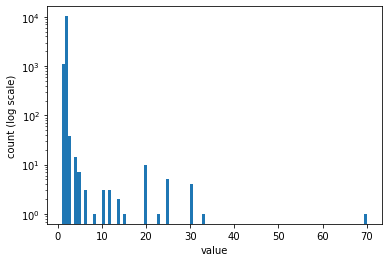

In [745]:
plt.hist(malawi_2019.hh_f26a, bins=100,);
plt.yscale('log')
plt.xlabel('value');
plt.ylabel('count (log scale)');

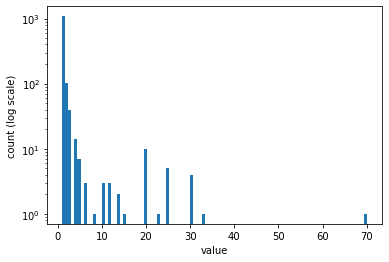

In [752]:
malawi_2019.hh_f26a_nan.value_counts()
plt.hist(malawi_2019[malawi_2019.hh_f26a_nan == 0].hh_f26a, bins=100,);
plt.yscale('log')
plt.xlabel('value');
plt.ylabel('count (log scale)');

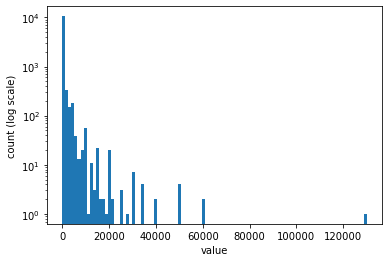

In [757]:
plt.hist(malawi_2019.yearly_rent, bins=100);
plt.yscale('log')
plt.xlabel('value');
plt.ylabel('count (log scale)');

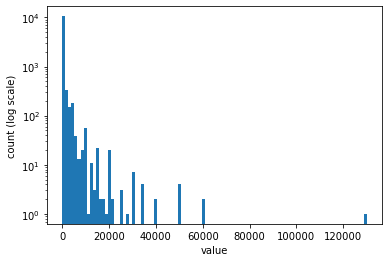

In [758]:
plt.hist(malawi_2019.hh_f35_2, bins=100);
plt.yscale('log')
plt.xlabel('value');
plt.ylabel('count (log scale)');

In [760]:
malawi_2019.hh_f35_2_nan.value_counts()

hh_f35_2_nan
0.0    6104
1.0    5330
Name: count, dtype: int64

#### Windorize/remove outliers

In [781]:
case_ids_to_drop = []
winsorize = False
for _, row in outlier_info.iterrows():

    if row.field in ('outcome', 'asset_index'):
        case_ids_to_drop.append(row.case_id)
    else:
        if winsorize:
            clipped_value = means[row.field] + NUM_STDS * (row.z_score / abs(row.z_score)) * stds[row.field]
            malawi_2019_outlier_processed.loc[malawi_2019_outlier_processed.case_id==row.case_id, row.field] = clipped_value

malawi_2019_outlier_processed = malawi_2019[~malawi_2019.case_id.isin(case_ids_to_drop)]

##### Check

In [ ]:
maximums = means + NUM_STDS * stds

for field, v in maximums.items():
    if field in ('outcome', 'asset_index'):
        continue
    num_exceeding = len(malawi_2019_outlier_processed[malawi_2019_outlier_processed[field] > v])
    if num_exceeding == 0:
        continue
    print(field, v)
    display(num_exceeding)


### Write results

In [782]:
if True:
    out_path = Path('/home/selker/eop/data/malawi')
    malawi_2019_outlier_processed.to_parquet(out_path / 'malawi_cleaned_2019.parquet', index=False)
    summary_2019.set_index('covariate', drop=True).to_parquet(out_path / 'malawi_summary_2019.parquet')

### Calculate baseline poverty rate

In [95]:
out_path = Path('/home/selker/eop/data/malawi')
malawi_stashed = pd.read_parquet(out_path / 'malawi_cleaned_2016.parquet')
summary_stashed = pd.read_parquet(out_path / 'malawi_summary_2016.parquet')

In [7]:
poverty_line = 2.15
below = len(malawi[malawi.outcome < poverty_line])
total = len(malawi)

rate = below / total
display(rate)

0.6417307692307692

# 2018 Census

In [64]:
census = pd.read_csv(malawi_directory / 'census_2018_pop_tables.csv', header=1)
census.dropna(subset='Area', inplace=True)

In [72]:
regions = [c[7:] for c in malawi.columns if 'region' in c]
districts = [c[9:] for c in malawi.columns if 'district' in c]

In [68]:
regions

['Central', 'North', 'Southern']

In [63]:
display(census)

,Area,Total,Less than 1 Year,1-4,5-9,10-14,15-19,20-24,25-29,30-34,...,Unnamed: 11,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75+
0,Malawi,"17,563,749","522,802","2,029,604","2,632,878","2,533,303","2,035,945","1,651,576","1,229,411","1,107,226",...,Malawi,"968,998","729,600","535,868","387,812","306,921","234,918","240,551","144,788","271,548"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Northern,"2,289,780","63,749","255,335","339,840","340,115","274,854","219,632","154,384","139,341",...,Northern,"117,574","94,666","69,657","57,721","43,661","34,645","28,236","20,607","35,763"
3,Chitipa,"234,927","6,313","25,492","36,269","35,726","28,094","21,979","15,796","13,812",...,Chitipa,"11,381","9,576","7,703","6,130","4,438","3,233","2,914","2,123","3,948"
4,TA Mwabulambya,"67,232","1,695","6,957","10,188","10,204","8,145","6,555","4,536","3,975",...,TA Mwabulambya,"3,251","2,723","2,245","1,893","1,276",966,864,627,"1,132"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,Green Corner Ward,"22,609",581,"2,116","2,675","2,706","2,619","2,678","2,118","1,960",...,Green Corner Ward,"1,646","1,258",743,479,333,250,210,102,135
437,Soche West Ward,"37,847","1,017","3,429","4,393","4,334","4,195","4,627","3,844","3,525",...,Soche West Ward,"2,968","1,963","1,229",807,547,404,272,149,144
438,Namiyango Ward,"48,642","1,302","4,952","6,112","6,187","5,775","5,680","4,567","4,000",...,Namiyango Ward,"3,286","2,212","1,452","1,007",689,567,428,206,220
439,Chigumula Ward,"24,869",724,"2,578","3,241","3,280","2,804","2,607","2,031","1,833",...,Chigumula Ward,"1,671","1,293",769,556,414,344,279,178,267
